# Task 3: Piece Detection + Digital Twin

In [97]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import torchvision.ops as ops
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

random.seed(42)

## Load dataset

In [82]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Prep Dataset

In [83]:
def label_correct(id):
    return 0 if id == 12 else id + 1

i = 0
def label_correct_annotations(filepath):
    anns = json.load(open(filepath))
    for i in range(len(anns['categories'])):
        anns['categories'][i]['id'] = label_correct(anns['categories'][i]['id'])
    for i in range(len(anns['annotations']['pieces'])):
        anns['annotations']['pieces'][i]['category_id'] = label_correct(anns['annotations']['pieces'][i]['category_id'])
    
    fp = './chessred2k/label_corrected_annotations.json'
    with open(fp, 'w') as f:
        json.dump(anns, f)

label_correct_annotations('./chessred2k/annotations.json')

FileNotFoundError: [Errno 2] No such file or directory: './chessred2k/annotations.json'

### Original DSET

In [ ]:
class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.root = root_dir
        self.anns = json.load(open(os.path.join(root_dir, 'label_corrected_annotations.json')))

        self.id_to_category = {c['id']: c['name'] for c in self.anns['categories']}
        self.category_to_id = {c['name']: c['id'] for c in self.anns['categories']}
        self.categories = [c['name'] for c in self.anns['categories']]

        # --- Step 1: Pre-process ALL annotations and identify problematic images ---
        self.all_image_ids_from_json = []
        self.all_file_names_from_json = []
        for img_info in self.anns['images']:
            self.all_file_names_from_json.append(img_info['path'])
            self.all_image_ids_from_json.append(img_info['id'])
        self.all_image_ids_from_json = np.asarray(self.all_image_ids_from_json) # Convert to numpy for easy indexing/masking

        problematic_image_ids = set() # Store image_ids that have any malformed piece annotation
        # This will store ONLY VALID annotations, grouped by image_id
        self.image_annotations = {}

        for ann_idx, ann in enumerate(self.anns['annotations']['pieces']):
            # Ensure required attributes for object detection are present
            if 'bbox' not in ann or 'category_id' not in ann:
                #print(f"Warning: Annotation at index {ann_idx} for image_id {ann.get('image_id', 'N/A')} is malformed (missing 'bbox' or 'category_id'). This image will be excluded.")
                if 'image_id' in ann:
                    problematic_image_ids.add(ann['image_id'])
                continue # Skip this malformed annotation

            image_id = ann['image_id']
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
            self.image_annotations[image_id].append(ann)


        # --- Step 2: Filter images based on split and problematic annotations ---
        if partition == 'train':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else: # 'test'
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        self.file_names = [] # Final list of file names for this split
        self.image_ids = []  # Final list of original image IDs for this split

        # Iterate through all images (which you already have indexed by self.all_image_ids_from_json)
        for i, img_id in enumerate(self.all_image_ids_from_json):
            # Check if image belongs to current split AND is not marked as problematic
            if img_id in raw_split_image_ids and img_id not in problematic_image_ids:
                # Also, ensure that the image actually has valid annotations after filtering.
                # An image could be in the split, not problematic, but simply have no pieces.
                # Or all its pieces were problematic, so it has no valid annotations left.
                if img_id in self.image_annotations and len(self.image_annotations[img_id]) > 0:
                    self.image_ids.append(img_id)
                    self.file_names.append(self.all_file_names_from_json[i])
                else:
                    # Optional: Print why an image might be excluded if it's in the split but has no valid annotations
                    print(f"Info: Image ID {img_id} (file: {self.all_file_names_from_json[i]}) in '{partition}' split has no valid annotations after initial filtering. Excluding.")

        self.file_names = np.asarray(self.file_names)
        self.image_ids = np.asarray(self.image_ids)

        self.transform = transform

        print(f"Number of {partition} images: {len(self.file_names)}")


    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.file_names[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_image_id = self.image_ids[idx] # Get the true original ID for this image in the split
        # Retrieve annotations using the pre-processed dictionary
        annotations_for_image = self.image_annotations.get(original_image_id, [])

        boxes = []
        labels = []

        # Iterate through the (already filtered and valid) annotations for this image
        for ann in annotations_for_image:
            x_min, y_min, width, height = ann['bbox']
            x_max = x_min + width
            y_max = y_min + height
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(ann['category_id'])

        # Convert to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32) if len(boxes) > 0 else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if len(labels) > 0 else torch.zeros((0,), dtype=torch.int64)

        # Create the target dictionary required by Faster R-CNN
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([original_image_id])
        }

        if self.transform:
            image = self.transform(image)

        return image, target

train_dataset = ChessDataset('./chessred2k', 'train', data_aug)
valid_dataset = ChessDataset('./chessred2k', 'valid', data_in)
test_dataset = ChessDataset('./chessred2k', 'test', data_in)

### Cheat DSET

In [84]:
def get_perspective_transform(src_pts):
    dst_pts = np.array([
        [OFFSET, OFFSET],
        [512-OFFSET, OFFSET],
        [512-OFFSET, 512-OFFSET],
        [OFFSET, 512-OFFSET]
    ], dtype=np.float32)
    M = cv2.getPerspectiveTransform(np.array(src_pts, dtype=np.float32), dst_pts)
    return M

def warp_boxes(boxes, M):
    if len(boxes) == 0:
        return torch.zeros((0, 4), dtype=torch.float32)
    warped = []
    for box in boxes:
        x1, y1, x2, y2 = box
        pts = np.array([
            [x1, y1],
            [x2, y1],
            [x2, y2],
            [x1, y2]
        ], dtype=np.float32).reshape(-1, 1, 2)
        warped_pts = cv2.perspectiveTransform(pts, M).reshape(-1, 2)
        x_min, y_min = np.min(warped_pts, axis=0)
        x_max, y_max = np.max(warped_pts, axis=0)
        warped.append([x_min, y_min, x_max, y_max])
    return warped

In [90]:
OFFSET = 50

class CheatDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None, corners=False, warp=False):
        self.root = root_dir
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))

        self.id_to_category = {c['id']: c['name'] for c in self.anns['categories']}
        self.category_to_id = {c['name']: c['id'] for c in self.anns['categories']}
        self.categories = [c['name'] for c in self.anns['categories']]
        self.corners_f = corners
        self.warp_f = warp 
        if self.corners_f:
            # Load corner annotations
            self.corners = {}
            for corner_data in self.anns['annotations']['corners']:
                self.corners[corner_data['image_id']] = [
                    corner_data['corners']['top_left'],
                    corner_data['corners']['top_right'],
                    corner_data['corners']['bottom_right'],
                    corner_data['corners']['bottom_left']
                ]

        self.all_image_ids_from_json = []
        self.all_file_names_from_json = []
        for img_info in self.anns['images']:
            self.all_file_names_from_json.append(img_info['path'])
            self.all_image_ids_from_json.append(img_info['id'])

        self.all_image_ids_from_json = np.asarray(self.all_image_ids_from_json)

        problematic_image_ids = set()
        self.image_annotations = {}

        for ann in self.anns['annotations']['pieces']:
            if 'bbox' not in ann or 'category_id' not in ann:
                if 'image_id' in ann:
                    problematic_image_ids.add(ann['image_id'])
                continue
            image_id = ann['image_id']
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
            self.image_annotations[image_id].append(ann)

        if partition == 'train':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        self.file_names = []
        self.image_ids = []

        for i, img_id in enumerate(self.all_image_ids_from_json):
            if img_id in raw_split_image_ids and img_id not in problematic_image_ids:
                if img_id in self.image_annotations and len(self.image_annotations[img_id]) > 0:
                    if self.corners_f:
                        if img_id in self.corners:  # only keep if corner data is available
                            self.image_ids.append(img_id)
                            self.file_names.append(self.all_file_names_from_json[i])
                    else:
                        self.image_ids.append(img_id)
                        self.file_names.append(self.all_file_names_from_json[i])
        self.file_names = np.asarray(self.file_names)
        self.image_ids = np.asarray(self.image_ids)
        self.transform = transform

        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def get_corners(self, idx):
        if self.corners_f:
            image_id = self.image_ids[idx]
            corners = self.corners[image_id]
            return corners

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.file_names[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_id = self.image_ids[idx]
        boxes = []
        labels = []

        for ann in self.image_annotations[image_id]:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        if self.corners_f and self.warp_f:
            corners = self.corners[image_id]
            M = get_perspective_transform(corners)
            image = cv2.warpPerspective(image, M, (512, 512))
            boxes = warp_boxes(boxes, M)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([image_id])
        }

        if self.transform:
                image = self.transform(image)

        return image, target


In [91]:
train_dataset = CheatDataset('', 'train', data_aug, corners=True, warp=False)
valid_dataset = CheatDataset('', 'valid', data_in, corners=True, warp=False)
test_dataset = CheatDataset('', 'test', data_in, corners=True, warp=False)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


## Actual Load

In [ ]:
# Device configuration (improved version)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Hyperparameters (consider these adjustments)
batch_size = 8  # Reduced from 16 for better memory management with Faster R-CNN
num_workers = 0  # Optimal for most systems

def collate_fn(batch):
    """
    Enhanced collate function for object detection.
    Handles:
    - Empty targets
    - Image tensor conversion
    - Device movement
    """
    images, targets = zip(*batch)
    
    processed_images = []
    processed_targets = []
    
    for image, target in zip(images, targets):
        # Convert image if not already a tensor
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        
        # Handle empty targets
        if len(target['boxes']) == 0:
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros((0,), dtype=torch.int64)
        else:
            assert target['boxes'].shape[1] == 4, "Bounding boxes must have shape [N, 4]"
            
        processed_images.append(image)
        processed_targets.append(target)
    
    return processed_images, processed_targets

# DataLoaders with improved settings
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True  # Prevents partial batches
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True  # Keep all validation samples
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,  # Often better to use batch_size=1 for testing
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True
)

### Dataset Checks

In [ ]:
for i, (images, targets) in enumerate(valid_dataloader):
    print(f"\nBatch {i}:")
    for j, t in enumerate(targets):
        print(f"  Target {j}:")
        print(f"    Boxes shape: {t['boxes'].shape}")
        print(f"    Labels shape: {t['labels'].shape}")
        if t['boxes'].shape[0] != t['labels'].shape[0]:
            print("    Inconsistency!")
    
    if i >= 4:
        break

In [ ]:
#checking if the dataset is loaded correctly
for i in range(len(valid_dataset)):
    _, target = valid_dataset[i]
    assert target['boxes'].dim() == 2 and target['boxes'].shape[1] == 4

In [ ]:
# validating dataset with pieces

def plot_boxes(image, boxes, title="Detections"):
    plt.imshow(image)
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        plt.gca().add_patch(rect)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Ejemplo de uso con tus datos:
image, target = train_dataset[1]
denorm_img = (image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)) + \
             torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
denorm_img = denorm_img.permute(1, 2, 0).cpu().numpy()
denorm_img = np.clip(denorm_img, 0, 1)

plot_boxes(denorm_img, target['boxes'], "Ground Truth")

## Defining the model

We will use a pre-trained Faster RCNN ResNet50 network.

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    

num_classes = 13  # 12 pieces + empty space
    

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.005
momentum = 0.9
weight_decay = 0.0005
step_size = 3 
gamma = 0.1

# Optimizador y scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, 
                     momentum=momentum, 
                     weight_decay=weight_decay)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

### Train Model

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    
    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch}')
    
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        loss_classifier += loss_dict.get('loss_classifier', 0).item()
        loss_box_reg += loss_dict.get('loss_box_reg', 0).item()
        loss_objectness += loss_dict.get('loss_objectness', 0).item()
        loss_rpn_box_reg += loss_dict.get('loss_rpn_box_reg', 0).item()
        
        progress_bar.set_postfix({
            'Loss': total_loss/(progress_bar.n+1),
            'Cls': loss_classifier/(progress_bar.n+1),
            'Box': loss_box_reg/(progress_bar.n+1)
        })
    
    return total_loss / len(data_loader)

In [ ]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.train()
    total_loss = 0.0
    processed_batches = 0
    
    # Configuración especial para evitar errores de dimensiones
    original_score_thresh = model.roi_heads.score_thresh
    model.roi_heads.score_thresh = 0.0  # Desactiva filtrado inicial
    
    for batch_idx, (images, targets) in enumerate(tqdm(data_loader, desc='Validating')):
        # 1. Conversión explícita y verificación
        images = [img.to(device) for img in images]
        targets = [{
            'boxes': t['boxes'].float().to(device),
            'labels': t['labels'].long().to(device)
        } for t in targets]
        
        # 3. Forward pass con manejo de excepciones interno
        loss_dict = model(images, targets)
        
        # 4. Cálculo de pérdida unificado
        if isinstance(loss_dict, dict):
            losses = sum(loss for loss in loss_dict.values())
        else:  # Caso raro de lista de diccionarios
            losses = sum(sum(l.values()) for l in loss_dict)
        
        total_loss += losses
        processed_batches += 1
                
    
    # Restaura configuración original
    model.roi_heads.score_thresh = original_score_thresh

    return total_loss / processed_batches

In [ ]:
num_epochs = 3

def train_model(model, optimizer, lr_scheduler, train_dataloader, valid_dataloader, device, num_epochs, model_path, early_stop_patience=3):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        # Entrenamiento
        train_loss = train_one_epoch(model, optimizer, train_dataloader, device, epoch)
        
        # Validación
        val_loss = evaluate(model, valid_dataloader, device)
        lr_scheduler.step()
        
        # Guardar mejor modelo
        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            patience_counter = 0
            print(f"¡Nuevo mejor modelo guardado! (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping en epoch {epoch+1}")
                break
        
        # Log de progreso
        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)

    print("¡Entrenamiento completado!")

In [ ]:
train_model(model, optimizer, lr_scheduler, train_dataloader, valid_dataloader, device, num_epochs, '13classes_warped.pth')

## Load Model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, 13)
# Cargar mejor modelo
model.load_state_dict(torch.load('13classes_base.pth', map_location=device))
model.to(device)

## Evaluate Model

In [30]:
def custom_nms(predictions, iou_threshold=0.5):
    filtered_preds = []

    for pred in predictions:
        boxes = pred['boxes']
        scores = pred['scores']
        labels = pred['labels']

        if boxes.numel() == 0:
            filtered_preds.append(pred)
            continue

        # Apply NMS with no pre-filtering
        keep_idxs = ops.nms(boxes, scores, iou_threshold=iou_threshold)

        # Keep only those selected by NMS
        filtered_preds.append({
            'boxes': boxes[keep_idxs],
            'scores': scores[keep_idxs],
            'labels': labels[keep_idxs]
        })

    return filtered_preds

def plot_prediction(model, image, target, debug=False):
    img_tensor = image.unsqueeze(0).to(device)
        
    with torch.no_grad():
        prediction = model(img_tensor)
    
    # Procesamiento de la imagen para visualización
    denorm_img = (image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)) + \
                    torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    denorm_img = denorm_img.permute(1, 2, 0).cpu().numpy()
    denorm_img = np.clip(denorm_img, 0, 1)
    
    # Visualizar
    fig, ax = plt.subplots(1, 3, figsize=(15, 7))
    
    # Ground Truth
    ax[0].imshow(denorm_img)
    for box in target['boxes']:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=1, edgecolor='g', facecolor='none'
        )
        ax[0].add_patch(rect)
    ax[0].set_title('Ground Truth')
    ax[0].axis('off')

    ax[1].imshow(denorm_img) 
    for box in prediction[0]['boxes']:
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax[1].add_patch(rect)
    ax[1].set_title('Predictions')
    ax[1].axis('off')
    
    # Predicciones
    ax[2].imshow(denorm_img)

    filtered_preds = custom_nms(prediction)   
    for box in filtered_preds[0]['boxes']:
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax[2].add_patch(rect)
    ax[2].set_title('Predictions')
    ax[2].axis('off')
    
    plt.show()

def plot_predictions(model, dataset, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        image, target = dataset[idx]
        plot_prediction(model, image, target)
        



In [ ]:
plot_predictions(model, test_dataset, num_samples=1)

In [31]:
def test_model(model, device, data_loader, iou_threshold=0.5):
    model.eval()

    all_preds = []
    all_targets = []

    total_mse = 0.0
    matched_count = 0
    total_fp = 0
    total_fn = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc='Testing'):
            images = [img.to(device) for img in images]
            targets = [{
                'boxes': t['boxes'].float().to(device),
                'labels': t['labels'].long().to(device)
            } for t in targets]

            predictions = model(images)

            for pred, gt in zip(predictions, targets):
                pred_boxes = pred['boxes']
                pred_labels = pred['labels']
                pred_scores = pred['scores']

                gt_boxes = gt['boxes']
                gt_labels = gt['labels']

                if pred_boxes.numel() == 0:
                    # No predictions — all GTs are false negatives
                    all_targets.extend(gt_labels.cpu().tolist())
                    all_preds.extend([-1] * len(gt_labels))  # -1 = no prediction
                    total_fn += len(gt_labels)
                    continue

                if gt_boxes.numel() == 0:
                    # No GT — all predictions are false positives
                    all_targets.extend([-1] * len(pred_labels))
                    all_preds.extend(pred_labels.cpu().tolist())
                    total_fp += len(pred_labels)
                    continue

                ious = ops.box_iou(gt_boxes, pred_boxes)  # [num_gt, num_pred]
                gt_matched = set()
                pred_matched = set()

                for gt_idx in range(len(gt_boxes)):
                    iou_row = ious[gt_idx]
                    max_iou, pred_idx = torch.max(iou_row, dim=0)

                    if max_iou >= iou_threshold and pred_idx.item() not in pred_matched:
                        # Match found
                        gt_label = gt_labels[gt_idx].item()
                        pred_label = pred_labels[pred_idx].item()

                        all_targets.append(gt_label)
                        all_preds.append(pred_label)

                        # Bounding box MSE
                        mse = F.mse_loss(
                            pred_boxes[pred_idx],
                            gt_boxes[gt_idx],
                            reduction='mean'
                        ).item()
                        total_mse += mse
                        matched_count += 1

                        gt_matched.add(gt_idx)
                        pred_matched.add(pred_idx.item())
                    else:
                        # No good match found
                        continue

                # Count false negatives (GTs not matched)
                for gt_idx in range(len(gt_boxes)):
                    if gt_idx not in gt_matched:
                        all_targets.append(gt_labels[gt_idx].item())
                        all_preds.append(-1)
                        total_fn += 1

                # Count false positives (preds not matched)
                for pred_idx in range(len(pred_boxes)):
                    if pred_idx not in pred_matched:
                        all_targets.append(-1)
                        all_preds.append(pred_labels[pred_idx].item())
                        total_fp += 1

    # Filter out unmatched (-1) before computing classification metrics
    y_true = torch.tensor([t for t in all_targets if t != -1])
    y_pred = torch.tensor([p for t, p in zip(all_targets, all_preds) if t != -1])
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    avg_mse = total_mse / matched_count if matched_count > 0 else float('inf')

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"MSE (boxes): {avg_mse:.4f}")

    return accuracy, precision, recall, f1, avg_mse

In [ ]:
# Without Board extraction preprocessing
test_model(model, device, test_dataloader)

In [ ]:
# With
test_model(model, device, test_dataloader)

## Digital Twin

## Yolo

In [ ]:

model = YOLO("yolo11n.pt") 

results = model.train(data="yolo_dataset/dataset.yaml", 
                      epochs=100, imgsz=640, device="cpu", 
                      batch=8, project="chess_board_detection", 
                      name="yolo11n_run",
                      patience=10,
                      pretrained=True )



New https://pypi.org/project/ultralytics/8.3.152 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.147 🚀 Python-3.13.2 torch-2.7.0 CPU (Apple M4)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_run2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto

train: Scanning /Users/santiagoromero/Documents/cv/-Detect_the_chess_board_and_chess_pieces/yolo_dataset/train/labels... 1442 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1442/1442 [00:00<00:00, 6133.04it/s]

train: New cache created: /Users/santiagoromero/Documents/cv/-Detect_the_chess_board_and_chess_pieces/yolo_dataset/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1784.2±101.8 MB/s, size: 1766.4 KB)



val: Scanning /Users/santiagoromero/Documents/cv/-Detect_the_chess_board_and_chess_pieces/yolo_dataset/val/labels... 330 images, 0 backgrounds, 0 corrupt: 100%|██████████| 330/330 [00:00<00:00, 5998.02it/s]

val: New cache created: /Users/santiagoromero/Documents/cv/-Detect_the_chess_board_and_chess_pieces/yolo_dataset/val/labels.cache
Plotting labels to chess_board_detection/yolo11n_run2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to chess_board_detection/yolo11n_run2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G     0.9973      3.438     0.9078         39        640: 100%|██████████| 181/181 [05:11<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.52s/it]

                   all        330       6132      0.407      0.376      0.354      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/100         0G     0.7377      1.476     0.8416         84        640: 100%|██████████| 181/181 [05:02<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.51s/it]

                   all        330       6132      0.577      0.692       0.67      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      3/100         0G     0.6442     0.9983     0.8269         67        640: 100%|██████████| 181/181 [05:02<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.51s/it]

                   all        330       6132      0.752      0.828      0.844      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      4/100         0G     0.5915     0.8468     0.8187         41        640: 100%|██████████| 181/181 [05:00<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.50s/it]

                   all        330       6132      0.869      0.892      0.933      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      5/100         0G     0.5453     0.7378     0.8132         93        640: 100%|██████████| 181/181 [04:57<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.50s/it]

                   all        330       6132      0.939       0.93      0.969      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      6/100         0G     0.5314     0.6555     0.8126         46        640: 100%|██████████| 181/181 [04:58<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.49s/it]

                   all        330       6132      0.957      0.961      0.984      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      7/100         0G     0.5094     0.5999     0.8115         34        640: 100%|██████████| 181/181 [04:59<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.52s/it]

                   all        330       6132      0.972      0.968      0.988      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      8/100         0G     0.4873     0.5635     0.8064         51        640: 100%|██████████| 181/181 [05:00<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.48s/it]

                   all        330       6132       0.98      0.964      0.991      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      9/100         0G     0.4947     0.5605     0.8069         12        640: 100%|██████████| 181/181 [04:57<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:53<00:00,  2.54s/it]

                   all        330       6132      0.969      0.953      0.988      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     10/100         0G     0.4894     0.5234     0.8063         33        640: 100%|██████████| 181/181 [04:56<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.49s/it]

                   all        330       6132       0.98      0.977      0.992      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/100         0G     0.4628     0.4894     0.8041         57        640: 100%|██████████| 181/181 [05:14<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:51<00:00,  2.45s/it]

                   all        330       6132      0.984      0.978      0.993      0.832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     12/100         0G     0.4588     0.4768      0.804        116        640: 100%|██████████| 181/181 [05:17<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:51<00:00,  2.45s/it]

                   all        330       6132      0.986       0.98      0.993      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     13/100         0G     0.4473     0.4628     0.8034         45        640: 100%|██████████| 181/181 [05:28<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:51<00:00,  2.46s/it]

                   all        330       6132      0.985      0.983      0.993      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     14/100         0G     0.4436     0.4463     0.8007         63        640: 100%|██████████| 181/181 [05:29<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:51<00:00,  2.46s/it]

                   all        330       6132      0.989      0.985      0.994      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     15/100         0G     0.4518     0.4431     0.7996         51        640: 100%|██████████| 181/181 [05:32<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:52<00:00,  2.49s/it]

                   all        330       6132      0.991      0.979      0.994      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     16/100         0G     0.4327     0.4269     0.7989         49        640: 100%|██████████| 181/181 [05:27<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:51<00:00,  2.47s/it]

                   all        330       6132      0.989      0.988      0.994      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     17/100         0G     0.4412      0.432     0.7986        123        640: 100%|██████████| 181/181 [05:26<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:51<00:00,  2.46s/it]

                   all        330       6132      0.984      0.988      0.994      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     18/100         0G     0.4331     0.4168     0.7988         70        640: 100%|██████████| 181/181 [05:27<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:51<00:00,  2.46s/it]

                   all        330       6132       0.99      0.987      0.994      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     19/100         0G     0.4278     0.4013     0.7964         88        640: 100%|██████████| 181/181 [06:24<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [15:49<00:00, 45.22s/it]  

                   all        330       6132      0.994      0.987      0.995      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     20/100         0G     0.4239     0.3984     0.7973         40        640: 100%|██████████| 181/181 [39:58<00:00, 13.25s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:56<00:00,  2.68s/it]

                   all        330       6132      0.988       0.99      0.995       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     21/100         0G     0.4091     0.3879     0.7956        125        640: 100%|██████████| 181/181 [07:23<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:14<00:00,  3.53s/it]

                   all        330       6132      0.995      0.988      0.995      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     22/100         0G     0.4078     0.3791      0.796         58        640: 100%|██████████| 181/181 [07:38<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:17<00:00,  3.69s/it]

                   all        330       6132      0.993      0.987      0.994      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     23/100         0G     0.4168     0.3804     0.7971        101        640: 100%|██████████| 181/181 [07:50<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:22<00:00,  3.95s/it]

                   all        330       6132      0.993      0.989      0.995      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     24/100         0G     0.4045     0.3719     0.7951         67        640: 100%|██████████| 181/181 [07:46<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:21<00:00,  3.88s/it]

                   all        330       6132      0.993       0.99      0.995      0.839
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 14, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

24 epochs completed in 3.472 hours.
Optimizer stripped from chess_board_detection/yolo11n_run2/weights/last.pt, 5.5MB


Optimizer stripped from chess_board_detection/yolo11n_run2/weights/best.pt, 5.5MB

Validating chess_board_detection/yolo11n_run2/weights/best.pt...
Ultralytics 8.3.147 🚀 Python-3.13.2 torch-2.7.0 CPU (Apple M4)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:15<00:00,  3.60s/it]


                   all        330       6132      0.989      0.985      0.994      0.868
            white-pawn        330       1625      0.999      0.994      0.995      0.858
            white-rook        281        447      0.998      0.994      0.995      0.848
          white-knight        220        274          1      0.991      0.995      0.861
          white-bishop        235        335      0.997      0.991      0.995       0.86
           white-queen        126        126      0.984      0.986      0.993        0.9
            white-king        330        330      0.995      0.991      0.995       0.91
            black-pawn        330       1511      0.991      0.994      0.995      0.862
            black-rook        280        471          1      0.992      0.995      0.874
          black-knight        125        178      0.978      0.972      0.992      0.825
          black-bishop        223        380      0.992      0.952      0.993      0.849
           black-quee

In [ ]:
def predictions_to_board_matrix(boxes, labels, offset=20, board_size=512, squares=8):
    """
    Convert predicted bounding boxes and labels into an 8x8 board matrix,
    adjusting for homography offset padding.
    
    Parameters:
        boxes (Tensor or list of list): Nx4 format [[x1, y1, x2, y2], ...]
        labels (Tensor or list): length-N label list
        offset (int): pixel offset added during warp
        board_size (int): total size of the board image (typically 512)
        squares (int): number of squares per row/column (8 for standard chess)

    Returns:
        board_matrix: 8x8 numpy array with labels placed in appropriate squares
    """
    board = np.zeros((squares, squares), dtype=int) - 1
    square_size = (board_size - 2 * offset) / squares

    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        cx = ((x1 + x2) / 2) - offset
        cy = ((y1 + y2) / 2) - offset

        col = int(cx // square_size)
        row = int(cy // square_size)

        # Clamp to stay within bounds
        col = max(0, min(squares - 1, col))
        row = max(0, min(squares - 1, row))

        board[row, col] = int(label)

    return board


image 1/1 /Users/santiagoromero/Documents/cv/-Detect_the_chess_board_and_chess_pieces/images/0/G000_IMG000.jpg: 640x640 8 white-pawns, 2 white-rooks, 2 white-knights, 2 white-bishops, 1 white-queen, 1 white-king, 8 black-pawns, 2 black-rooks, 2 black-knights, 2 black-bishops, 1 black-queen, 1 black-king, 89.1ms
Speed: 6.8ms preprocess, 89.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


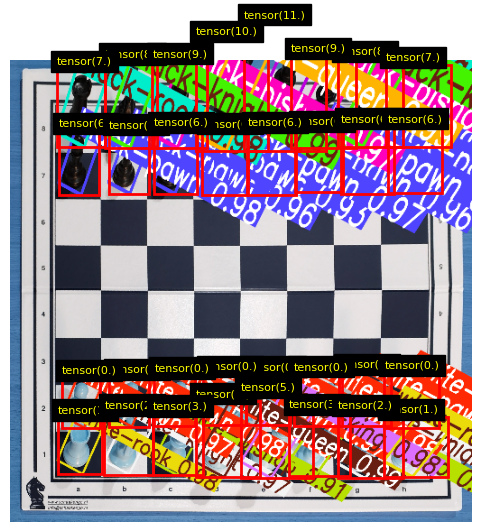

Boxes: tensor([[2409.8696, 1392.8127, 2556.1606, 1585.7567],
        [1670.9244, 1659.6250, 1826.8225, 1937.3599],
        [ 716.9563,  879.4881,  830.4432, 1085.6080],
        [1054.2838,  710.8134, 1186.1381,  967.5873],
        [1038.6631, 2015.3215, 1187.9781, 2227.1128],
        [1858.8534, 1549.6176, 2022.3036, 1847.6840],
        [1188.7332, 1766.6729, 1312.7256, 1934.9230],
        [1539.3036,  600.2928, 1642.7222,  794.0143],
        [1761.9484, 1507.0052, 1872.0688, 1670.2979],
        [2122.2378, 1341.4131, 2236.3118, 1509.7567],
        [ 526.9852,  962.4205,  652.9042, 1145.8793],
        [ 596.8809, 1115.3531,  704.5181, 1277.1844],
        [2289.2019, 1273.6213, 2405.2825, 1440.8470],
        [1385.1621,  644.0388, 1491.7919,  851.3057],
        [1151.9836,  923.1367, 1249.1908, 1076.6649],
        [ 974.2949, 1862.2881, 1099.1353, 2036.6687],
        [ 894.7576,  819.8502, 1006.7761, 1022.5585],
        [1476.8077,  802.8567, 1567.4351,  951.0942],
        [1262.3925, 1

13

In [ ]:
model = YOLO("chess_board_detection/yolo11n_run2/weights/best.pt")

# Predecir en una imagen
results = model.predict(
    source=test_dataset.file_names[0]
)


result = results[0]  # Get the first result
boxes = result.boxes.xyxy  # Coor [x1, y1, x2, y2]
labels = result.boxes.cls  # class id
confs = result.boxes.conf   # confidence scores


corners = test_dataset.get_corners(0)
M = get_perspective_transform(corners)

# === Warp image ===
warp_img = cv2.warpPerspective(result.plot(), M, (512, 512))

warped_boxes = warp_boxes(boxes, M)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(warp_img)

for box, label in zip(warped_boxes, labels):
    x1, y1, x2, y2 = box
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                    linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, str(label), color='yellow', fontsize=8, backgroundcolor='black')

plt.axis('off')
plt.show()

In [ ]:
print(predictions_to_board_matrix(warped_boxes, labels, offset=50))

[[ 7  8  9 10 11  9  8  7]
 [ 6  6  6  6  6  6  6  6]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0]
 [ 1  2  3  4  5  3  2  1]]
